# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', 500)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
adias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')
adias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
adias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [4]:
# having a look at columns with type object
print(adias['OST_WEST_KZ'].unique())
print(adias['CAMEO_INTL_2015'].unique())
print(adias['CAMEO_DEU_2015'].unique())
print(adias['CAMEO_DEUG_2015'].unique())

[nan 'W' 'O']
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
[nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']


In [5]:
adias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# check if feat_info column arrangement is the same that in the dataset
feat_info['attribute'].to_numpy() == adias.columns.to_numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [8]:
# convert missing/unknown values based on code in dataset to nan
col_names = feat_info['attribute'].to_numpy()
missing_codes_col = feat_info['missing_or_unknown'].to_numpy()

def convert_to_int(x):
    try:
        int(x)
    except (TypeError, ValueError):
        return x
    else:
        return int(x)

for col, code in zip(col_names, missing_codes_col):

    missing_codes_list = np.array(list(map(convert_to_int, code.strip('][').split(','))))
    adias[col].replace(to_replace=missing_codes_list, value=np.nan, inplace=True)

adias['AGER_TYP'].unique()
    

array([nan,  2.,  3.,  1.])

In [9]:
# check updated distribution of data in columns
adias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

In [10]:
num_rows = adias.shape[0]

# check proportion of missing values 
feat_info['missing_prop'] = adias.isnull().sum().divide(num_rows).to_numpy()

# columns with more than 25% missing/unknown values
feat_info[feat_info['missing_prop'] > 0.25]

,attribute,information_level,type,missing_or_unknown,missing_prop
0,AGER_TYP,person,categorical,"[-1,0]",0.769554
11,GEBURTSJAHR,person,numeric,[0],0.440203
40,TITEL_KZ,person,categorical,"[-1,0]",0.997576
43,ALTER_HH,household,interval,[0],0.348137
47,KK_KUNDENTYP,household,categorical,[-1],0.655967
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",0.534687


In [11]:
# remove features which have > 25% missing/unknown values
def remove_columns(data_df, info_df, remove_list):
    redundant_features_bool = info_df['attribute'].isin(remove_list)
    redundant_features_idx = info_df.loc[redundant_features_bool].index.to_numpy()

    adias_trimmed = data_df.drop(labels=remove_list, axis=1)
    feat_info_trimmed = info_df.drop(redundant_features_idx)

    return adias_trimmed, feat_info_trimmed

features_to_remove = feat_info[feat_info['missing_prop'] > 0.25]['attribute'].to_numpy()
adias_trimmed, feat_info_trimmed = remove_columns(adias, feat_info, features_to_remove)

print('adias dataset shape:', adias_trimmed.shape)
print('feat_info dataset shape:', feat_info_trimmed.shape)

adias dataset shape: (891221, 79)
feat_info dataset shape: (79, 5)


array([[<AxesSubplot:title={'center':'ALTERSKATEGORIE_GROB'}>,
        <AxesSubplot:title={'center':'ANREDE_KZ'}>,
        <AxesSubplot:title={'center':'CJT_GESAMTTYP'}>,
        <AxesSubplot:title={'center':'FINANZ_MINIMALIST'}>,
        <AxesSubplot:title={'center':'FINANZ_SPARER'}>,
        <AxesSubplot:title={'center':'FINANZ_VORSORGER'}>,
        <AxesSubplot:title={'center':'FINANZ_ANLEGER'}>,
        <AxesSubplot:title={'center':'FINANZ_UNAUFFAELLIGER'}>],
       [<AxesSubplot:title={'center':'FINANZ_HAUSBAUER'}>,
        <AxesSubplot:title={'center':'FINANZTYP'}>,
        <AxesSubplot:title={'center':'GFK_URLAUBERTYP'}>,
        <AxesSubplot:title={'center':'GREEN_AVANTGARDE'}>,
        <AxesSubplot:title={'center':'HEALTH_TYP'}>,
        <AxesSubplot:title={'center':'LP_LEBENSPHASE_FEIN'}>,
        <AxesSubplot:title={'center':'LP_LEBENSPHASE_GROB'}>,
        <AxesSubplot:title={'center':'LP_FAMILIE_FEIN'}>],
       [<AxesSubplot:title={'center':'LP_FAMILIE_GROB'}>,
        <A

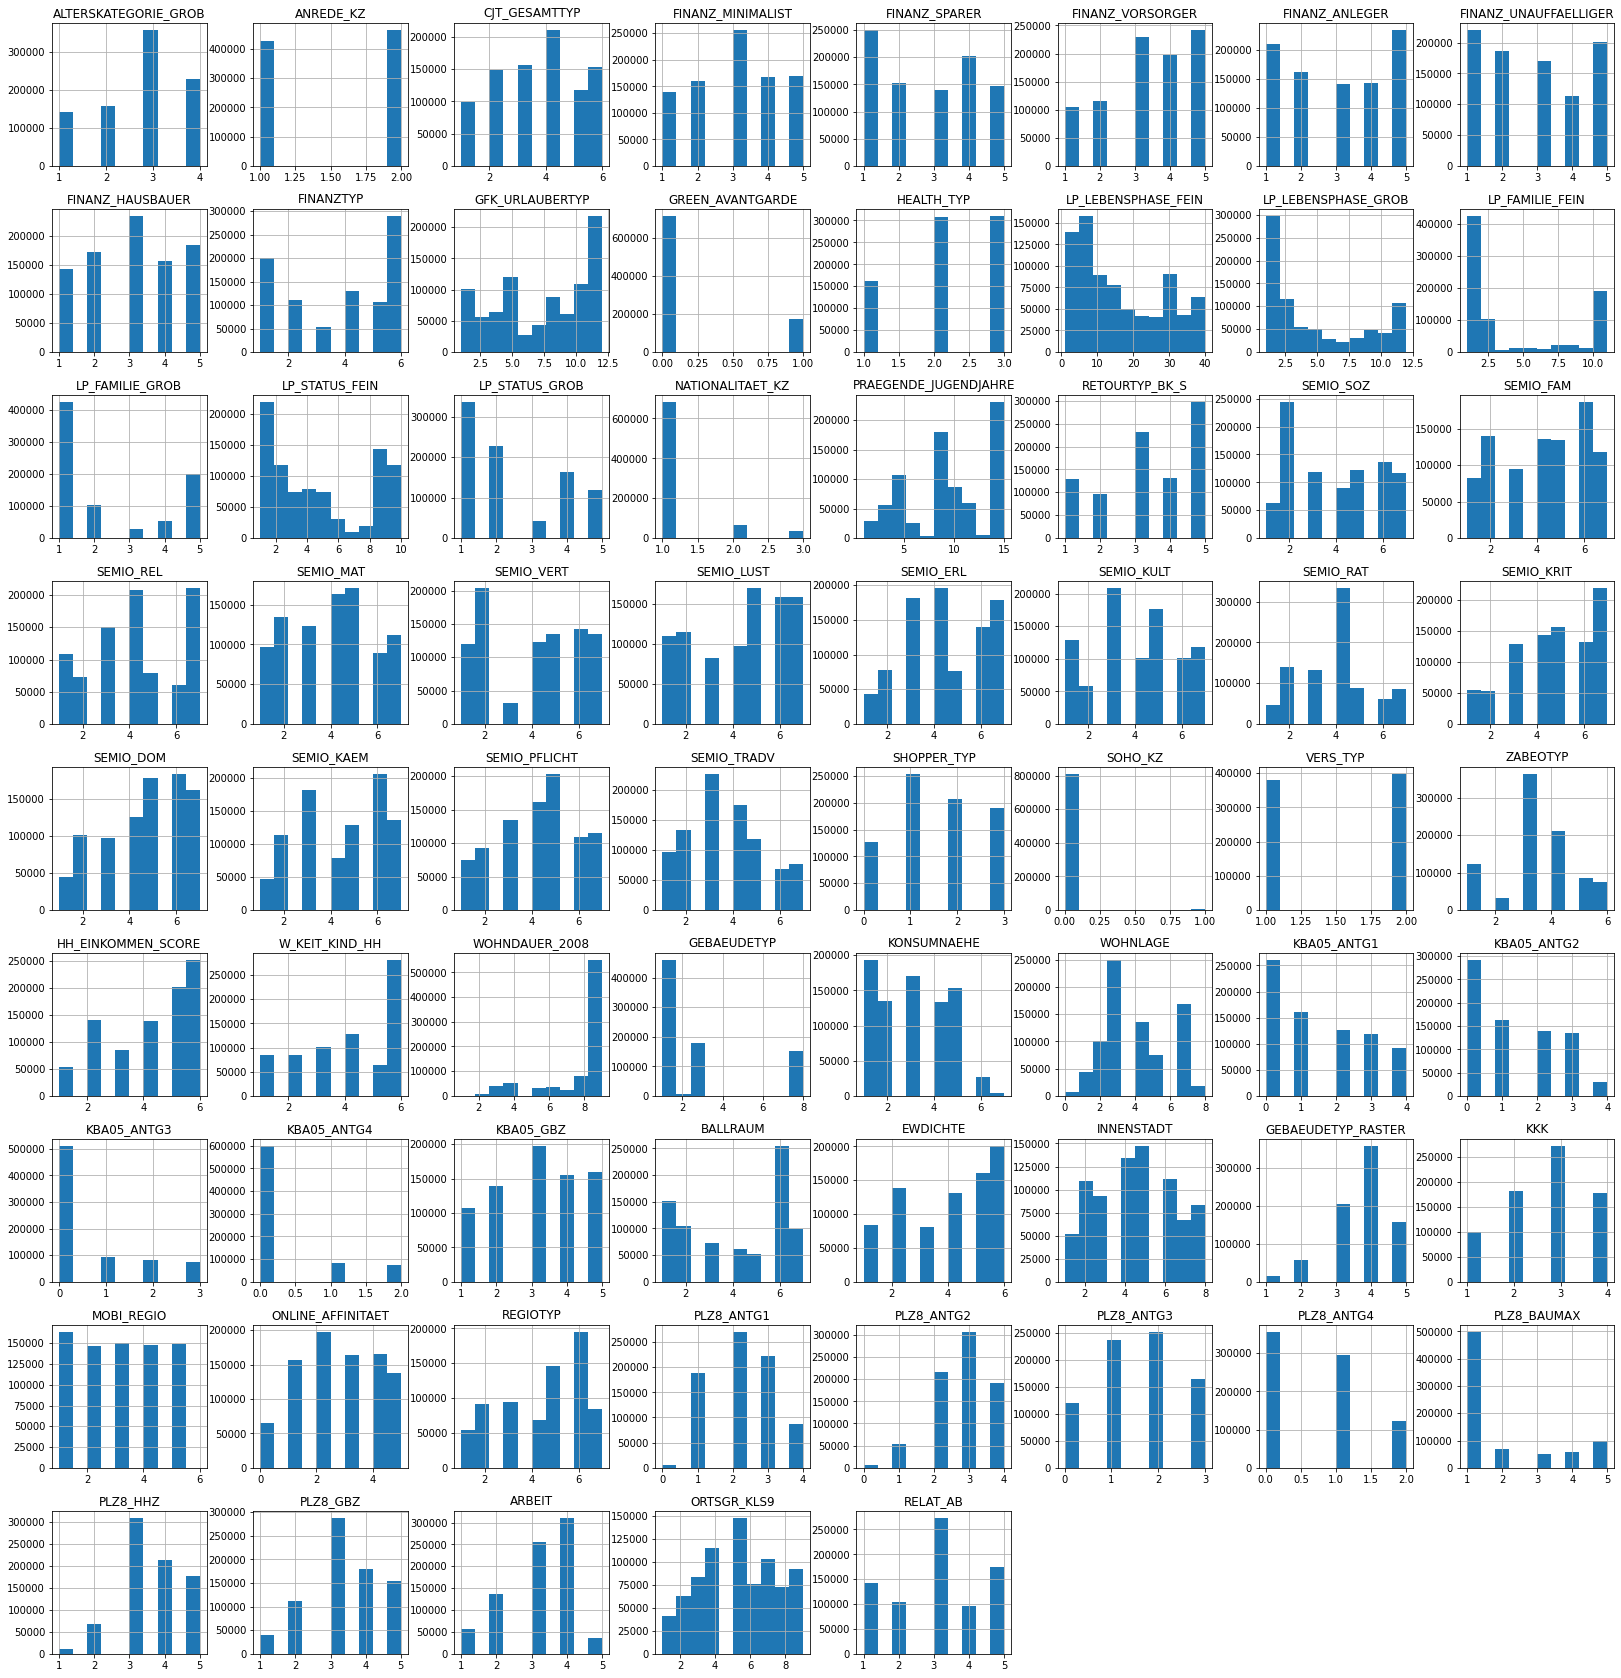

In [12]:
# plot histogram of values in non-numeric columns
non_numeric_col = feat_info_trimmed[feat_info_trimmed['type'] != 'numeric']['attribute'].to_numpy()
adias_trimmed[non_numeric_col].hist(figsize=(28,30))

In [13]:
# check distribution of data in numeric columns
numeric_col = feat_info_trimmed[feat_info_trimmed['type'] == 'numeric']['attribute'].to_numpy()
adias_trimmed[numeric_col].describe()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,817722.000000,817722.000000,791610.000000,794213.000000,798073.000000,785421.000000
mean,1.727637,0.004162,8.354924,0.040647,1993.277011,619.701439
std,1.155849,0.068855,15.673731,0.324028,3.332739,340.034318
min,0.000000,0.000000,1.000000,0.000000,1985.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,1992.000000,384.000000
50%,1.000000,0.000000,4.000000,0.000000,1992.000000,549.000000
75%,2.000000,0.000000,10.000000,0.000000,1993.000000,778.000000
max,45.000000,6.000000,595.000000,23.000000,2016.000000,2300.000000


In [14]:
# remove feature with one sided distribution
adias_trimmed, feat_info_trimmed = remove_columns(adias_trimmed, feat_info_trimmed, ['SOHO_KZ'])

print('adias dataset shape:', adias_trimmed.shape)
print('feat_info dataset shape:', feat_info_trimmed.shape)

adias dataset shape: (891221, 78)
feat_info dataset shape: (78, 5)


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
adias_trimmed.columns = pd.MultiIndex.from_tuples(zip(adias_trimmed.columns, feat_info_trimmed['information_level']))
adias_trimmed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
,person,person,person,person,person,person,person,person,person,person,...,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,community,community,community
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [16]:
adias_trimmed['missing_count'] = adias_trimmed.isnull().sum(axis=1).to_numpy()

# example of a row with more than 40 missing data
num_col_with_missing_data = 40
adias_trimmed[adias_trimmed['missing_count'] > num_col_with_missing_data].T

,,0,11,14,17,24,35,48,53,54,61,...,891063,891064,891072,891092,891095,891159,891164,891175,891185,891187
ALTERSKATEGORIE_GROB,person,2,2,3,2,3,2,3,2,3,3,...,1,3,2,3,1,2,3,3,3,3
ANREDE_KZ,person,1,1,1,1,2,2,2,1,1,2,...,2,1,1,2,1,1,2,2,1,2
CJT_GESAMTTYP,person,2,6,6,6,6,2,6,3,6,6,...,2,6,6,6,6,1,4,6,6,6
FINANZ_MINIMALIST,person,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
FINANZ_SPARER,person,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
FINANZ_VORSORGER,person,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
FINANZ_ANLEGER,person,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
FINANZ_UNAUFFAELLIGER,person,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
FINANZ_HAUSBAUER,person,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
FINANZTYP,person,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [18]:
# distribution of missing data seems to be in the same columns, let's drop them
missing_data_rows_idx = adias_trimmed[adias_trimmed['missing_count'] > num_col_with_missing_data].index
adias_trimmed.drop(missing_data_rows_idx, inplace=True)

# check remaining number of rows
print('Original dataset shape: ', adias.shape)
print('Trimmed dataset shape: ', adias_trimmed.shape)
print('Number of rows deleted: ', len(missing_data_rows_idx))

Original dataset shape:  (891221, 85)
Trimmed dataset shape:  (817245, 79)
Number of rows deleted:  73976


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
adias_trimmed.columns = adias_trimmed.columns.droplevel(1)

In [20]:
categorical_col = feat_info_trimmed[feat_info_trimmed['type'] == 'categorical']['attribute'].to_numpy()

# see unique values in each categorical column
for col in categorical_col:
    print('{}: {}'.format(col, adias_trimmed[col].unique()))

ANREDE_KZ: [2 1]
CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP: [1 6 5 2 4 3]
GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN_AVANTGARDE: [0 1]
LP_FAMILIE_FEIN: [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB: [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ: [ 1.  3.  2. nan]
SHOPPER_TYP: [ 3.  2.  1.  0. nan]
VERS_TYP: [ 2.  1. nan]
ZABEOTYP: [5 3 4 1 6 2]
GEBAEUDETYP: [ 8.  1.  3.  2. nan  6.  4.  5.]
OST_WEST_KZ: ['W' nan 'O']
CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


**Notes on Categorical columns:**

1. `ANREDE_KZ`: gender (male 1 vs female 2)
2. `CJT_GESAMTTYP`: customer-journey-topology
3. `FINANZTYP`:
    * financial type of individual
    * 6 can be converted to nan too
4. `GFK_URLAUBERTYP`:
    * vacation habits
    * quite a detailed breakdown
5. `GREEN_AVANTGARDE`: membership in enviromental sustainability as part of youth
6. `LP_FAMILIE_FEIN`:
    * family type, fine scale
    * **can possibly be dropped**
7. `LP_FAMILIE_GROB`: family type, rough scale
8. `NATIONALITAET_KZ`: nationality based on given name analysis
9. `SHOPPER_TYP`: shoper typology
10. `VERS_TYP`: insurance typology
11. `ZABEOTYP`: energy consumption typology
12. `GEBAEUDETYP`: building type (residential vs commercial)
13. `OST_WEST_KZ`: building location via former East / West Germany
14. `CAMEO_DEUG_2015`: Wealth / Life stage typology, rough scale
15. `CAMEO_DEU_2015`:
    * Wealth / Life stage typology, detailed scale
    * **can possibly be dropped**

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# drop 2 columns
categorical_col = np.delete(categorical_col, [5,14])
adias_trimmed, feat_info_trimmed = remove_columns(adias_trimmed, feat_info_trimmed, ['LP_FAMILIE_FEIN', 'CAMEO_DEU_2015'])

# let's use one hot encoding
adias_trimmed_enc = pd.get_dummies(data=adias_trimmed, columns=categorical_col)

adias_trimmed_enc.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,0,0,0,0,0,0,1,0


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
mixed_col = feat_info_trimmed[feat_info_trimmed['type'] == 'mixed']['attribute'].to_numpy()
mixed_col

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'PLZ8_BAUMAX'], dtype=object)

**Notes on Mixed columns:**

1. `LP_LEBENSPHASE_FEIN`:
    * life-stage, fine scale
    * **can possibly be removed**
2. `LP_LEBENSPHASE_GROB`: life-stage, rough scale
3. `PRAEGENDE_JUGENDJAHRE`:
    * dominating movement of person's youth (avantgarde vs mainstream, east vs west)
    * **can possibly be split into avantgarde vs mainstream and east vs west**
4. `WOHNLAGE`:
    * neighbourhood quality (rural flag)
    * looks like an ordinal column
5. `CAMEO_INTL_2015`:
    * german cameo - wealth/lifestyle typology, mapped to international code
    * **can possibly be split into wealth_typology and life_stage_typology features**
6. `PLZ8_BAUMAX`:
    * most common building type within the PLZ8 region
    * **can possibly be split into family vs business building and number of members within family home**

In [ ]:
adias_trimmed, feat_info_trimmed = remove_columns(adias_trimmed, feat_info_trimmed, ['LP_LEBENSPHASE_FEIN'])

# split LP_LEBENSPHASE_GROB to LP_LEBENSPHASE_GROB_INC and LP_LEBENSPHASE_GROB_HH
split_dict = {
    LP_LEBENSPHASE_GROB_INC: ['low', 'low', 'high', 'low', 'high', np.nan, 'low', 'high', np.nan, 'low', 'high', 'high'],
     LP_LEBENSPHASE_GROB_HH: []
}

In [ ]:
# split PRAEGENDE_JUGENDJAHRE into PRAEGENDE_JUGENDJAHRE_DC and PRAEGENDE_JUGENDJAHRE_MVM
